IS6400 21/22 Semester B

- Week 7: Time Series (I) solution to in-class exercises

Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as SP_STATS

In [2]:
import statsmodels.api as sm
from sklearn import metrics

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
# if running in Google Colab, please run the following line
# !pip install --upgrade statsmodels

---

# The question

Use the ['AustralianWine.csv'](https://raw.githubusercontent.com/zhiyzuo/IS6400-Regression/main/Data/AustralianWines.csv) with columns `Month` and `Red` and conduct the following exercise. Use the codes in the lecture notes for your reference (please create a new empty Jupyter notebook for this exercise):
1. Visualize the time series using a line plot.
2. Use `statsmodels` to visualize the autocorrelation plot.
3. In combination with the line plot in step 1 and the KPSS test, explain whether this time series is stationary or not.
4. Use the Holt-Winter's method to forecast.
    - Think about what kind of trend/seasonality you want to use bsaed on the previous data exploration.
    - Use fixed partition such that the training consists of 90% of the time and the testing set. Visualize the outcome:
        1. Observed and predicted time series.
        2. Forecast errors in both training and testing samples.

---

# Data and visualization

In [ ]:
#wine = pd.read_csv('../Data/AustralianWines.csv', usecols=['Month', 'Red'], dtype={'Red': int})

In [11]:
url = 'https://raw.githubusercontent.com/zhiyzuo/IS6400-Regression/main/Data/AustralianWines.csv'
wine = pd.read_csv(url)

In [12]:
wine

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226
...,...,...,...,...,...,...,...
175,Aug-94,2294,2665,*,1495,205,3670
176,Sep-94,2416,2639,46,2968,259,4221
177,Oct-94,2016,2226,51,3385,254,4404
178,Nov-94,2799,2586,63,3729,275,5086


In [13]:
wine.columns

Index(['Month', 'Fortified', 'Red', 'Rose ', 'sparkling ', 'Sweet white',
       'Dry white'],
      dtype='object')

In [14]:
wine = wine.set_index('Month')['Red']
wine.head(2)

Month
Jan-80    464
Feb-80    675
Name: Red, dtype: int64

In [15]:
## we need ask python to recognize the index as a date-time object
wine.index = pd.to_datetime(wine.index, format='%b-%y')

In [16]:
wine.head()

Month
1980-01-01     464
1980-02-01     675
1980-03-01     703
1980-04-01     887
1980-05-01    1139
Name: Red, dtype: int64

In [17]:
type(wine)

pandas.core.series.Series

## Line chart and stationarity

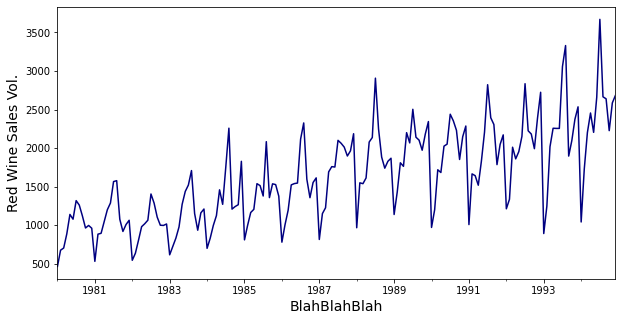

In [30]:
## a single line chart
fig, ax = plt.subplots(figsize=[10, 5])
wine.plot(ax=ax, color='navy')
ax.set_xlabel('BlahBlahBlah', size=14)
_ = ax.set_ylabel('Red Wine Sales Vol.', size=14)

Seems like there is steady trend but the seasonality component seems to be growing. Confirm with a KPSS test

In [35]:
## there is a convention that underscores can be used for unwanted variables in python
_, pval, __, ___ = sm.tsa.stattools.kpss(wine, nlags='auto')
print('p-Value of the KPSS test: %.3f'%pval)

p-Value of the KPSS test: 0.010


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Indeed, the null hypothesis of this time series being stationary is rejected.

## Autocorrelation

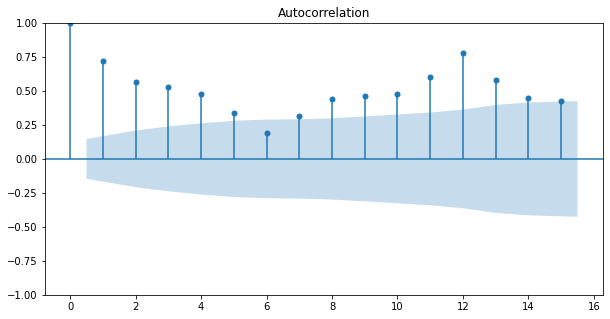

In [39]:
## the shaded region is the 95% CI
## you could try vary the number of lags to show autocorrelations beyond lag-10
fig, ax = plt.subplots(figsize=[10, 5])
_ = sm.graphics.tsa.plot_acf(wine, lags=15, ax=ax, zero=True)

This shows positive autocorrelation.

---

# Forecasting

We may want to use an additive trend with multiplicative seasonality in the Winter's model to forecast. Whether a damped trend is needed is not very clear - we may try both models with and without for comparison.

Split the dataset into 90% for training and 10% for testing:

In [42]:
int(0.9 * wine.size)

162

In [44]:
N_train = int(0.9 * wine.size)
N_test = wine.size - N_train
print("Training set vs. testing set: %i vs. %i"%(N_train, N_test))

Training set vs. testing set: 162 vs. 18


Train and test models

In [46]:
# need to change the data structure for using the tsa api
wine = wine.resample('M').mean()
wine.size

180

In [47]:
wine

Month
1980-01-31     464.0
1980-02-29     675.0
1980-03-31     703.0
1980-04-30     887.0
1980-05-31    1139.0
               ...  
1994-08-31    2665.0
1994-09-30    2639.0
1994-10-31    2226.0
1994-11-30    2586.0
1994-12-31    2684.0
Freq: M, Name: Red, Length: 180, dtype: float64

In [48]:
## train-test split by slicing
wine_train = wine.iloc[:N_train]
wine_test = wine.iloc[N_train:]
wine_train.size, wine_test.size

(162, 18)

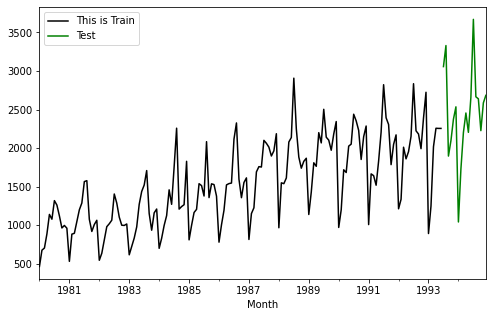

In [54]:
fig, ax = plt.subplots(figsize=[8, 5])
wine_train.plot(ax=ax, color='k', label='This is Train')
wine_test.plot(ax=ax, color='g', label='Test')
_ = ax.legend(prop={'size': 10})

We are going to use a dictionary to save models in a key-value pair structure.

In [55]:
mod_dict = dict()

Can you identify what these models are?
- HINT: check out what values we set to the arguments of `error`, `trend`, `damped_trend`, and `seasonal`.

In [56]:
mod_dict['(A, A)'] = sm.tsa.ETSModel(wine_train, error='add',
                                     trend='add', damped_trend=False,
                                     seasonal='add', seasonal_periods=12).fit(maxiter=1e5, disp=False)

In [57]:
mod_dict['(A, M)'] = sm.tsa.ETSModel(wine_train, error='add',
                                     trend='add', damped_trend=False,
                                     seasonal='mul', seasonal_periods=12).fit(maxiter=1e5, disp=False)

In [58]:
mod_dict['(Ad, M)'] = sm.tsa.ETSModel(wine_train, error='add',
                                      trend='add', damped_trend=True,
                                      seasonal='mul', seasonal_periods=12).fit(maxiter=1e5, disp=False)

In [59]:
mod_dict

{'(A, A)': <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x137b36040>,
 '(A, M)': <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x137b9ed30>,
 '(Ad, M)': <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x137c487f0>}

Evaluate

In [63]:
print('Model\t Train RMSE\t Test RMSE\t')
## compute MSE value for the training and testing part respectively
for mod_name, mod in mod_dict.items():
    mod_mse_fitted = metrics.mean_squared_error(y_pred=mod.fittedvalues, y_true=wine_train)
    mod_mse_forecast = metrics.mean_squared_error(y_pred=mod.forecast(N_test),
                                                  y_true=wine_test)
    ## use string formatter to print out the values neatly
    print('%s\t %.3f\t %.3f'%(mod_name, np.sqrt(mod_mse_fitted), np.sqrt(mod_mse_forecast)))

Model	 Train RMSE	 Test RMSE	
(A, A)	 204.999	 310.278
(A, M)	 179.887	 295.925
(Ad, M)	 188.222	 331.767


Visualize

In [18]:
# this is for scatter plot
#kargs_dict = {'(A, A)': {'marker': '.', 's': 50, 'color': 'r'},
#              '(A, M)': {'marker': '+', 's': 50, 'color': 'g'},
#              '(Ad, M)': {'marker': 'x', 's': 50, 'color': 'navy'}
#             }

In [45]:
kargs_dict = {'(A, A)': {'ls': 'dashed', 'color': 'r'},
              '(A, M)': {'ls': 'dotted', 'color': 'g'},
              '(Ad, M)': {'ls': '-.', 'color': 'navy'}
             }

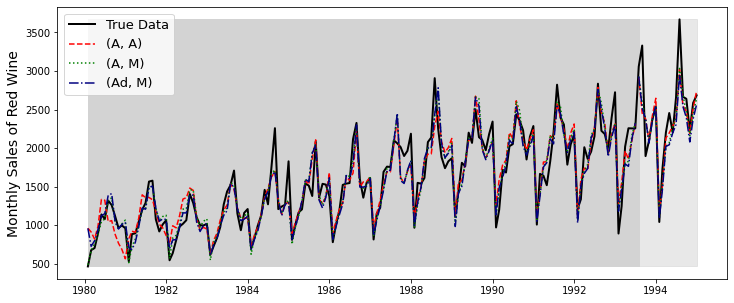

In [47]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(wine.index, wine.values,
        linestyle='-', linewidth=2,
        label='True Data', color='k')
## plot each model separately
for mod_name, mod in mod_dict.items():
    ## we could also use scatter plot 
    #ax.scatter(wine_train.index, mod.fittedvalues, **kargs_dict[mod_name])
    #ax.scatter(wine_test.index, mod.forecast(N_test), label=mod_name, **kargs_dict[mod_name])
    ## this is the code for line plot
    ax.plot(wine_train.index, mod.fittedvalues, **kargs_dict[mod_name])
    ax.plot(wine_test.index, mod.forecast(N_test), label=mod_name, **kargs_dict[mod_name])
## set up y-label
ax.set_ylabel('Monthly Sales of Red Wine', fontsize=14)
## these two `fill_betweenx` is for making different background colors for train/test
ax.fill_betweenx(np.linspace(wine.values.min(), wine.values.max()),
                 wine.index[0], wine.index[N_train], color='lightgray')
ax.fill_betweenx(np.linspace(wine.values.min(), wine.values.max()),
                 wine.index[N_train], wine.index[-1], color='lightgray', alpha=0.5)
## show legend
_ = ax.legend(prop={'size': 13})

Visualize the testing data part only

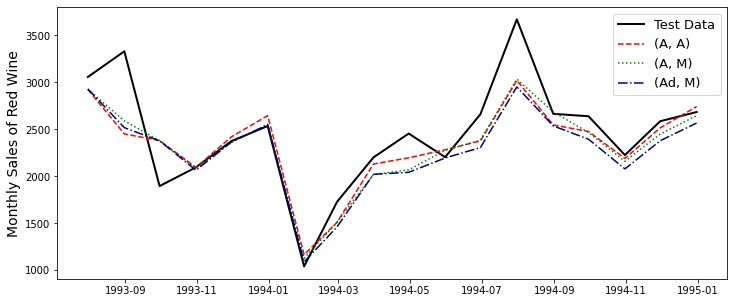

In [48]:
fig, ax = plt.subplots(figsize=[12, 5])
## plot the ground truth in solid line
ax.plot(wine_test.index, wine_test.values,
        linestyle='-', linewidth=2,
        label='Test Data', color='k')
## only forecasting for held-out test data for the three models
for mod_name, mod in mod_dict.items():
    ax.plot(wine_test.index, mod.forecast(N_test), label=mod_name, **kargs_dict[mod_name])
## Set a y-label
ax.set_ylabel('Monthly Sales of Red Wine', fontsize=14)
## show the legend
_ = ax.legend(prop={'size': 13})